# Clustering Analysis - Con y Sin PCA

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

df_log = pd.read_csv(r"C:\Users\patri\REPO_PRUEBA\ML_Customer_Segmentation\src\data_sample\wholesale_customers_log.csv")
df = pd.read_csv(r"C:\Users\patri\REPO_PRUEBA\ML_Customer_Segmentation\src\data_sample\wholesale_customers_final.csv")

In [2]:
corr_matrix = df.corr()
corr_matrix

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel,Region
Fresh,1.000000,-0.021096,-0.132989,0.386258,-0.158706,0.256442,-0.169481,0.013512
Milk,-0.021096,1.000000,0.761128,-0.055229,0.678725,0.342310,0.577282,0.034222
Grocery,-0.132989,0.761128,1.000000,-0.164525,0.797141,0.239998,0.662808,0.001835
Frozen,0.386258,-0.055229,-0.164525,1.000000,-0.212771,0.256318,-0.245034,-0.085294
Detergents_Paper,-0.158706,0.678725,0.797141,-0.212771,1.000000,0.167573,0.727093,0.014653
Delicassen,0.256442,0.342310,0.239998,0.256318,0.167573,1.000000,0.131209,-0.011199
Channel,-0.169481,0.577282,0.662808,-0.245034,0.727093,0.131209,1.000000,0.062028
Region,0.013512,0.034222,0.001835,-0.085294,0.014653,-0.011199,0.062028,1.000000


Channel: tiene correlación con algunas variables, la dejamos

Region: no tiene mucha correlación, la quitamos. 

# Codifico Channel

In [3]:
from sklearn.preprocessing import OneHotEncoder

# Si la variable Channel es categórica con más de dos valores
df_encoded = pd.get_dummies(df['Channel'], prefix='Channel')

# Supongamos que las variables numéricas están en df_log y df_encoded tiene las variables categóricas
df_updated = pd.concat([df_log, df_encoded], axis=1)


## Clustering con variables originales

In [4]:
# Definir número de clusters
n_clusters = 3

# Aplicar K-Means
kmeans_original = KMeans(n_clusters=n_clusters, random_state=42)
clusters_original = kmeans_original.fit_predict(df_updated)

# Añadir los clusters al DataFrame
df_updated['Cluster_Original'] = clusters_original

# Evaluar con Silhouette Score
silhouette_original = silhouette_score(df_updated.drop('Cluster_Original', axis=1), clusters_original)
print(f"Silhouette Score (Datos originales): {silhouette_original:.3f}")

Silhouette Score (Datos originales): 0.272


# PCA

In [5]:
pca = PCA()
df_pca = pca.fit_transform(df_updated)

Varianza explicada por cada componente: [0.43332515 0.2724257  0.10665048 0.08868072 0.04248544 0.02219133
 0.02040204 0.01383913 0.        ]
Varianza acumulada: [0.43332515 0.70575085 0.81240133 0.90108205 0.9435675  0.96575883
 0.98616087 1.         1.        ]


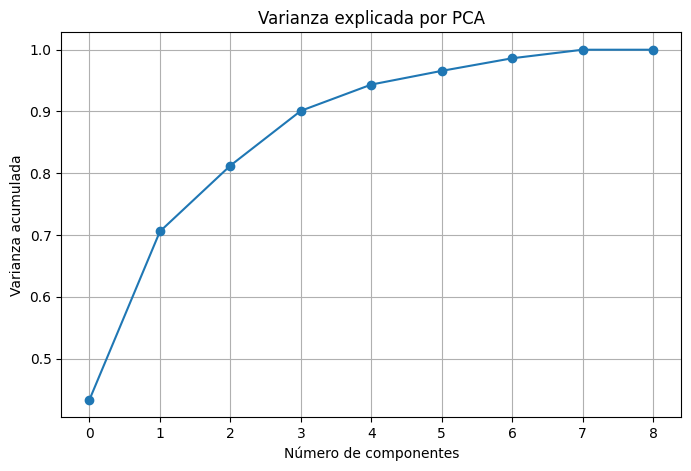

In [6]:
# Vemos la varianza explicada
explained_variance = pca.explained_variance_ratio_
print("Varianza explicada por cada componente:", explained_variance)
print("Varianza acumulada:", np.cumsum(explained_variance))

# Gráfica de varianza acumulada
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.title('Varianza explicada por PCA')
plt.grid(True)
plt.show()

* Con las 2 primeras componentes → 72% de la info

* Con 3 componentes → 83% 

* Con 4 componentes → 93% → casi toda la info

Probamos dos cosas: 

- Usar las variables orginales tras la ranformacion logaritima 
- Probar con PCA 

## Clustering con PCA

In [7]:
# Aplicar K-Means sobre los datos reducidos
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42)
clusters_pca = kmeans_pca.fit_predict(df_pca)

# Evaluar con Silhouette Score
silhouette_pca = silhouette_score(df_pca, clusters_pca)
print(f"Silhouette Score (Datos reducidos con PCA): {silhouette_pca:.3f}")

Silhouette Score (Datos reducidos con PCA): 0.306


## Comparación

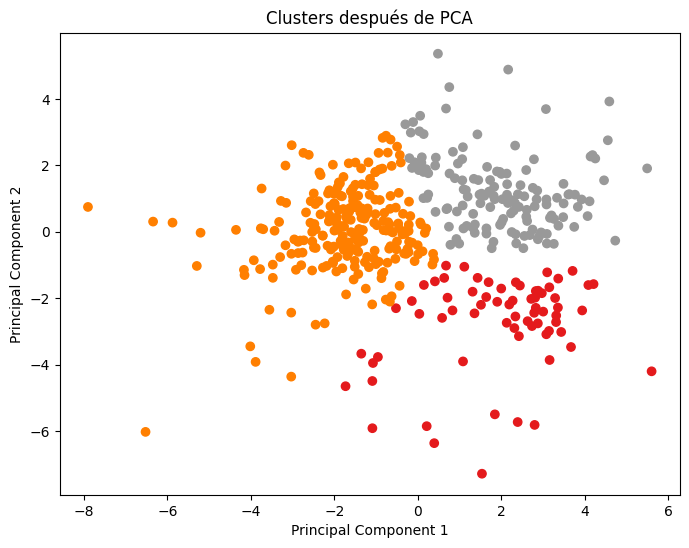

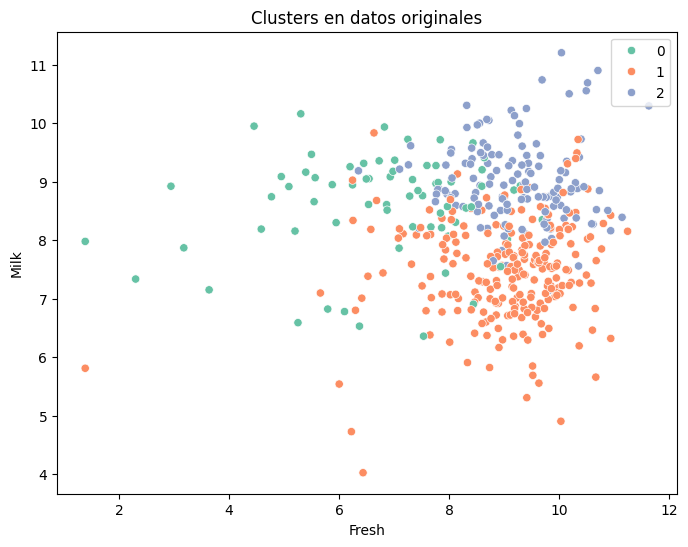

In [8]:
# Visualización Clusters con PCA
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters_pca, cmap='Set1')
plt.title('Clusters después de PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Opcional: Ver cómo quedaron los clusters originales
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_updated.iloc[:, 0], 
    y=df_updated.iloc[:, 1], 
    hue=df_updated['Cluster_Original'], 
    palette='Set2'
)
plt.title('Clusters en datos originales')
plt.xlabel(df_updated.columns[0])
plt.ylabel(df_updated.columns[1])
plt.legend()
plt.show()

Nos quedamos con el PCA, pero vamos a probar con dos algoritmos mas

## DBSCAN

DBSCAN no ha encontrado más de un cluster.


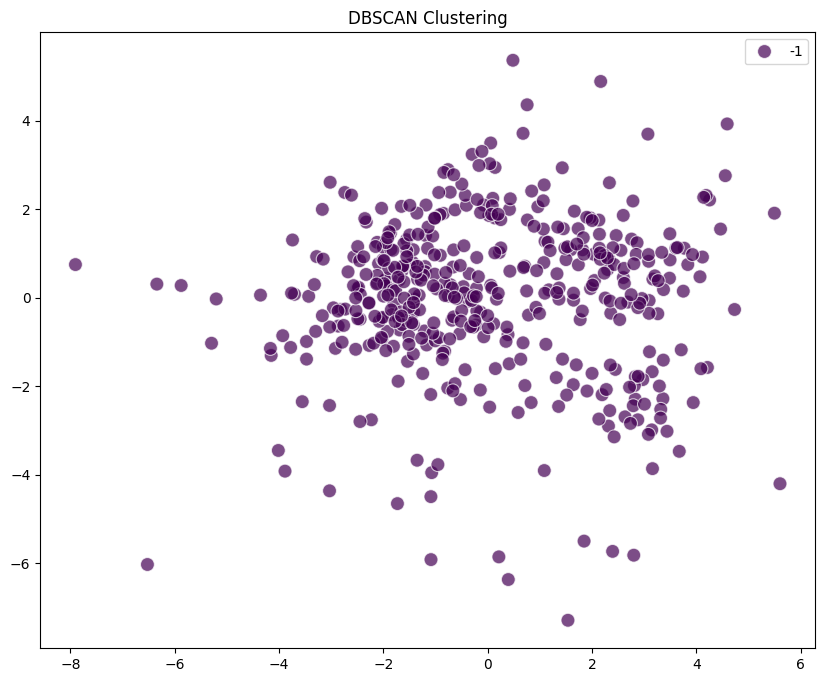

In [12]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Definir DBSCAN con los parámetros básicos
dbscan = DBSCAN(eps=0.02, min_samples=10)

# Ajustar el modelo DBSCAN
dbscan_labels = dbscan.fit_predict(df_pca)

# Evaluar el Silhouette Score
# Evaluar el Silhouette Score si hay más de un cluster
if len(np.unique(dbscan_labels)) > 1:
    silhouette_dbscan = silhouette_score(df_pca, dbscan_labels)
    print(f"Silhouette Score (DBSCAN): {silhouette_dbscan:.3f}")
else:
    print("DBSCAN no ha encontrado más de un cluster.")

# Visualizar los clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=dbscan_labels, palette="viridis", s=100, alpha=0.7)
plt.title("DBSCAN Clustering")
plt.show()

## Aglomerative clustering

Silhouette Score (Agglomerative Clustering): 0.2856597870249654


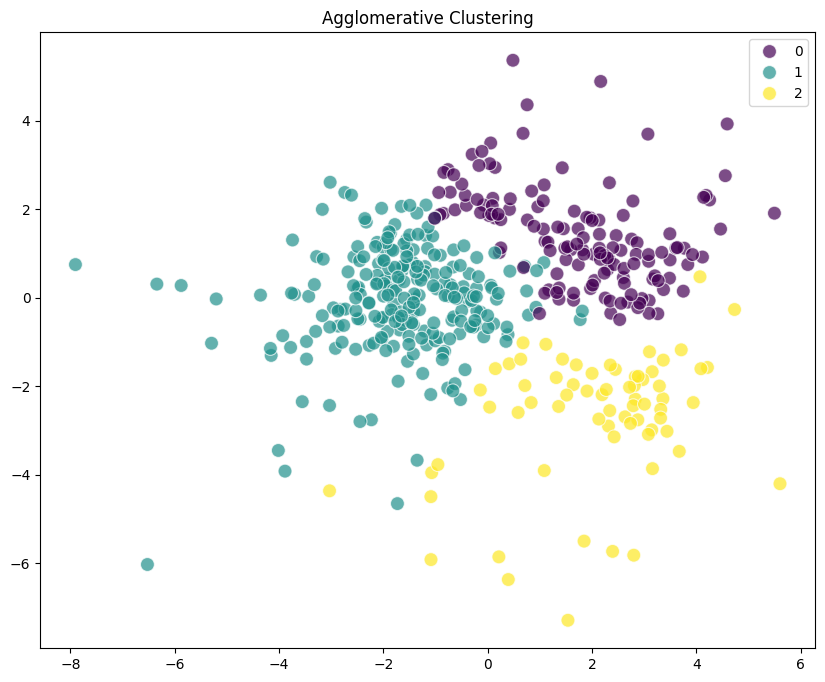

In [13]:
from sklearn.cluster import AgglomerativeClustering

# Definir Agglomerative Clustering
agg_clust = AgglomerativeClustering(n_clusters=n_clusters)  # Número de clusters, ajustable

# Ajustar el modelo
agg_clust_labels = agg_clust.fit_predict(df_pca)

# Evaluar el Silhouette Score
silhouette_agg_clust = silhouette_score(df_pca, agg_clust_labels)
print("Silhouette Score (Agglomerative Clustering):", silhouette_agg_clust)

# Visualizar los clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=agg_clust_labels, palette="viridis", s=100, alpha=0.7)
plt.title("Agglomerative Clustering")
plt.show()


## Comparamos los tres modelos

In [14]:
#SILHOUTTTE SCORE 
print(f"Silhouette Score (k-means): {silhouette_pca:.3f}")
#print("Silhouette Score (DBSCAN):", silhouette_dbscan)
print("Silhouette Score (Agglomerative Clustering):", silhouette_agg_clust)


Silhouette Score (k-means): 0.306
Silhouette Score (Agglomerative Clustering): 0.2856597870249654


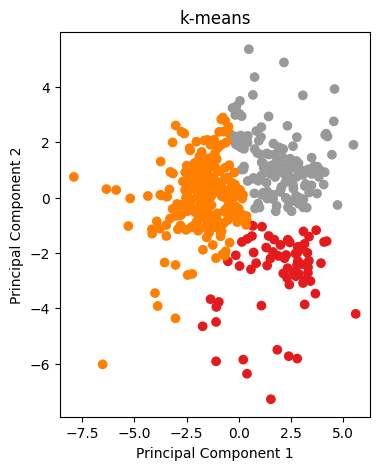

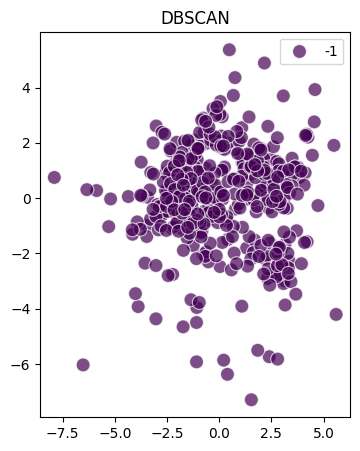

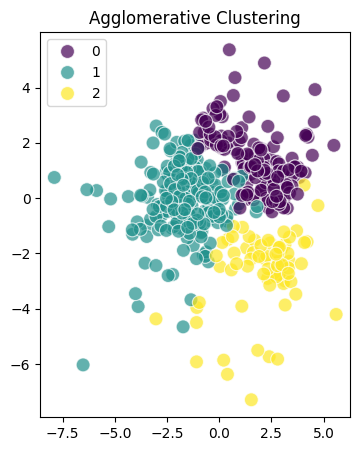

In [15]:
# k-means
plt.figure(figsize=(4, 5))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters_pca, cmap='Set1')
plt.title('k-means')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


# DBSCAN
plt.figure(figsize=(4, 5))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=dbscan_labels, palette="viridis", s=100, alpha=0.7)
plt.title("DBSCAN")
plt.show()

# Agglomerative Clustering
plt.figure(figsize=(4, 5))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=agg_clust_labels, palette="viridis", s=100, alpha=0.7)
plt.title("Agglomerative Clustering")
plt.show()


* K-Means tiene el mejor Silhouette Score y en el grafico los grupos estan bien definidos

* DBSCAN fatal, ha creado demasiados grupos y están mal definidos. Quizás por los outliers

* Agglomerative Clustering no tiene mal Silhouette Score, pero menor que k-means, e identofoca 4 grupos 


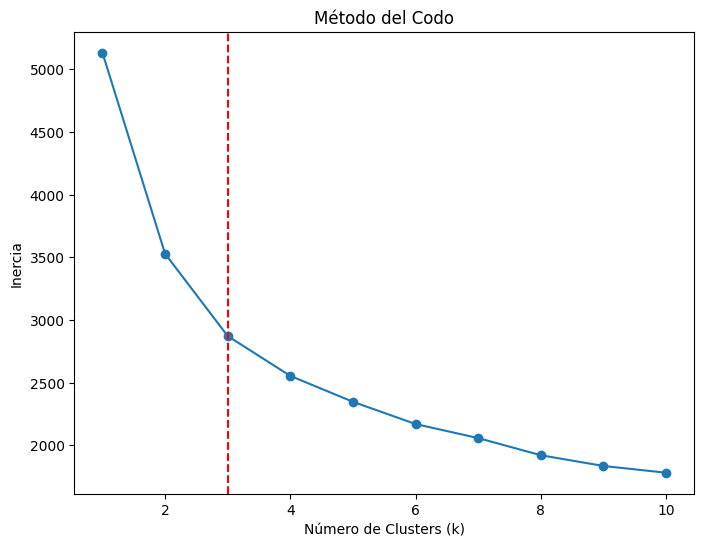

In [16]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Rango de números de clusters a probar
k_range = range(1, 11)  # Probar desde 1 hasta 10 clusters
inertia = []

# Ajustar K-Means para diferentes valores de k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)  # Asumiendo que los datos ya están escalados
    inertia.append(kmeans.inertia_)  # Guardar la inercia (suma de distancias)

# Graficar la inercia frente al número de clusters
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.axvline(x=n_clusters, color='red', linestyle='--', label=f'k óptimo = {n_clusters}')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.show()


In [19]:
# Obtener las características promedio de cada cluster
df_updated['Cluster'] = clusters_pca  # Suponiendo que clusters_pca es tu variable de clusters

# Calcular la media de cada característica para cada cluster
cluster_means = df_updated.groupby('Cluster').mean()

# Mostrar la media de cada variable para cada cluster
print(cluster_means)


            Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen  \
Cluster                                                                         
0        6.739585  8.589718  9.164429  5.799511          8.192726    5.575592   
1        9.028648  7.463828  7.692074  7.610076          5.533174    6.510385   
2        9.212022  8.995238  9.346301  7.524184          8.216179    7.476414   

         Channel_1  Channel_2  Cluster_Original  
Cluster                                          
0         0.367647   0.632353               0.0  
1         0.987124   0.012876               1.0  
2         0.309353   0.690647               2.0  
